# Time Series Project

# Daily Minimum Temperatures in Melbourne Predication Project

## Imports 

In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
import matplotlib.pyplot as plt

# Load Dataset

In [63]:
path="E:/Study DATA/Deep learning Projects/Daily Minimum Temperatures in Melbourne Predication (Time Series Project)/Dataset/Daily Minimum Temperatures in Melbourne.csv"
data=pd.read_csv(path)
data

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [64]:
time=np.arange(0,3650)
time[-1]

3649

In [65]:
values=data.iloc[:,-1]
values=np.array(values)

In [66]:
values
values[-1]

13.0

# Plot Dataset 

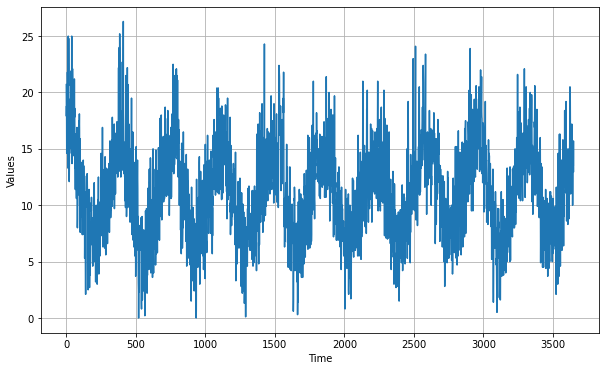

In [67]:
plt.figure(figsize=(10,6))
plt.plot(time,values)
plt.xlabel("Time")
plt.ylabel("Values")
plt.grid(True)

# Processing the data

## Splitting Data into Training and Validation 

In [68]:
split_time=2500

train_time=time[:split_time]
train_series=values[:split_time]

valid_time=time[split_time:]
valid_series=values[split_time:]

In [69]:
print("length of Train_Time: ",len(train_time))
print("length of Train_Series: ",len(train_series))
print("length of Validation_Time: ",len(valid_time))
print("length of Validation_Series: ",len(valid_series))

length of Train_Time:  2500
length of Train_Series:  2500
length of Validation_Time:  1150
length of Validation_Series:  1150


In [70]:
train_time.shape

(2500,)

### we will feed the data for training by creating a dataset with the appropiate processing steps such as 
`windowing`, `flattening`, `batching` and `shuffling`. 

In [71]:
window_size=64
batch_size=256
shuffer_buffer_size = 1000

In [72]:
def windowed_dataset(series, WINDOW_SIZE=window_size, BATCH_SIZE=batch_size, SHUFFER_BUFFER_SIZE=shuffer_buffer_size):
    
    # Create dataset from the series
    dataset=tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset=dataset.window(window_size+1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset=dataset.flat_map(lambda w: w.batch(window_size+1))
    
    # Shuffle it
    dataset=dataset.shuffle(shuffer_buffer_size)
    
    # Split it into the features and labels
    dataset=dataset.map(lambda w: (w[:-1], w[-1]))
    
    # Batch it
    dataset=dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [73]:
train_series_data=windowed_dataset(train_series)
train_series_data

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>

# Defining the Model Architecture

In [74]:
model=models.Sequential()

model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None,1] ))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))


In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 64)          256       
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 74,753
Trainable params: 74,753
Non-trainable params: 0
_________________________________________________________________


## Adjusting the learning rate
This is only changing the learning rate during the training process to give an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate.
hyperparameter optimization

In [15]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-4*10**(epoch/20))

model.compile(optimizer=optimizers.SGD(momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae'])

# Training

In [64]:
history=model.fit(train_series_data, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 12s 327ms/step - loss: 10.0929 - mae: 10.5917 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 3s 291ms/step - loss: 9.9766 - mae: 10.4753 - lr: 1.1220e-04
Epoch 3/100
10/10 [==============================] - 3s 285ms/step - loss: 9.8386 - mae: 10.3372 - lr: 1.2589e-04
Epoch 4/100
10/10 [==============================] - 3s 295ms/step - loss: 9.6733 - mae: 10.1717 - lr: 1.4125e-04
Epoch 5/100
10/10 [==============================] - 4s 395ms/step - loss: 9.4910 - mae: 9.9894 - lr: 1.5849e-04
Epoch 6/100
10/10 [==============================] - 5s 417ms/step - loss: 9.2725 - mae: 9.7709 - lr: 1.7783e-04
Epoch 7/100
10/10 [==============================] - 4s 367ms/step - loss: 9.0110 - mae: 9.5093 - lr: 1.9953e-04
Epoch 8/100
10/10 [==============================] - 4s 383ms/step - loss: 8.6922 - mae: 9.1902 - lr: 2.2387e-04
Epoch 9/100
10/10 [==============================] - 5s 475ms/step - loss: 8.2935 - mae: 8

(0.0001, 10.0, 0.0, 10.0)

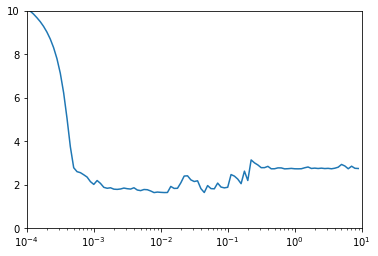

In [67]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

# Training with fixed Learning Rate

### Now that we have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series 

In [76]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.0079,momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae'])

In [77]:
history=model.fit(train_series_data, epochs=50)

Epoch 1/50
10/10 [==============================] - 9s 272ms/step - loss: 8.9637 - mae: 9.4614
Epoch 2/50
10/10 [==============================] - 3s 284ms/step - loss: 3.8446 - mae: 4.3212
Epoch 3/50
10/10 [==============================] - 3s 309ms/step - loss: 2.9338 - mae: 3.4014
Epoch 4/50
10/10 [==============================] - 4s 349ms/step - loss: 2.6990 - mae: 3.1665
Epoch 5/50
10/10 [==============================] - 4s 399ms/step - loss: 2.5984 - mae: 3.0639
Epoch 6/50
10/10 [==============================] - 4s 407ms/step - loss: 2.2998 - mae: 2.7598
Epoch 7/50
10/10 [==============================] - 5s 453ms/step - loss: 2.1041 - mae: 2.5628
Epoch 8/50
10/10 [==============================] - 5s 411ms/step - loss: 2.0576 - mae: 2.5134
Epoch 9/50
10/10 [==============================] - 5s 420ms/step - loss: 1.9675 - mae: 2.4228
Epoch 10/50
10/10 [==============================] - 4s 404ms/step - loss: 1.9783 - mae: 2.4368
Epoch 11/50
10/10 [==============================

## Evaluating the forecast

In [78]:
def compute_metrics(true_series, forecast):
    mse=tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae=tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    
    return mse, mae

In [79]:
def model_forecast(model, series, window_size):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size, shift=1, drop_remainder=True)
    dataset=dataset.flat_map(lambda w: w.batch(window_size))
    dataset=dataset.batch(32).prefetch(1)
    forecast=model.predict(dataset)
    
    return forecast

In [80]:
forecast=model_forecast(model, values, window_size).squeeze()
forecast= forecast[split_time-window_size:-1]

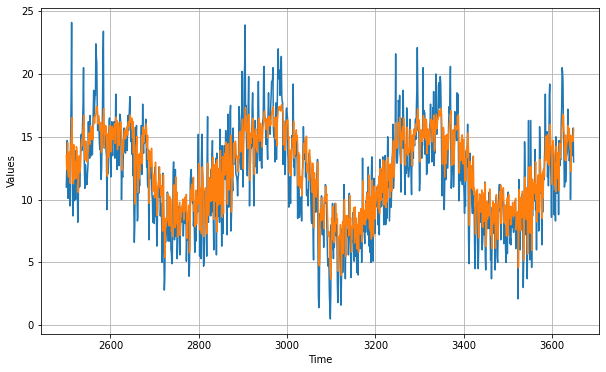

In [81]:
plt.figure(figsize=(10,6))
plt.plot(valid_time,valid_series)
plt.plot(valid_time,forecast)
plt.xlabel("Time")
plt.ylabel("Values")
plt.grid(True)

In [83]:
mse,mae= compute_metrics(valid_series, forecast)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Aboslute Error: {mae:.2f}")

Mean Squared Error: 5.76
Mean Aboslute Error: 1.88


In [84]:
model.save("E:/Study DATA/Deep learning Projects/Daily Minimum Temperatures in Melbourne Predication (Time Series Project)/Daily Minimum Temperatures in Melbourne Predication Model.h5")